<a href="https://colab.research.google.com/github/sftSalman/tensoflowMaster/blob/main/Custom_training_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

In [8]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir='./data/', download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/', download=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling data/fashion_mnist/3.0.1.incomplete3640GE/fashion_mnist-train.tfrecord*...:   0%|          | 0/60000…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling data/fashion_mnist/3.0.1.incomplete3640GE/fashion_mnist-test.tfrecord*...:   0%|          | 0/10000 …

Dataset fashion_mnist downloaded and prepared to ./data/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [34]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [9]:
def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [10]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

In [11]:
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)

test =  test_data.batch(batch_size=batch_size)

In [12]:
def base_model():
  inputs = tf.keras.Input(shape=(784,), name='digits')
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

In [13]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [14]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [15]:
def apply_grad(optimizer,model,x,y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)

  gradients = tape.gradient(loss_value,model.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model.trainable_weights))

  return logits , loss_value

In [21]:
def train_data():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))),position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ' )
  for step,(x_batch_train,y_batch_train) in enumerate(train):
    logits, loss_value = apply_grad(optimizer,model,x_batch_train,y_batch_train)
    losses.append(loss_value)
    train_acc_metric(y_batch_train, logits)
    pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
    pbar.update()
  return losses



In [22]:
def perform_validation():
  losses = []
  for x_val, y_val in test:
      val_logits = model(x_val)
      val_loss = loss_object(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

In [23]:
model = base_model()

In [24]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 64)                50240     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 predictions (Dense)         (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [25]:

model = base_model()

# Iterate over epochs.
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  
  losses_train = train_data()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

Start of epoch 0


Training loss for step 937: 0.2193: 100%|██████████| 938/938 



 Epoch 0: Train loss: 0.5411  Validation Loss: 0.4427, Train Accuracy: 0.8097, Validation Accuracy 0.8411
Start of epoch 1


Training loss for step 937: 0.3951: 100%|██████████| 938/938 



 Epoch 1: Train loss: 0.3907  Validation Loss: 0.4058, Train Accuracy: 0.8603, Validation Accuracy 0.8546
Start of epoch 2


Training loss for step 937: 0.2504: 100%|██████████| 938/938 



 Epoch 2: Train loss: 0.3577  Validation Loss: 0.3893, Train Accuracy: 0.8702, Validation Accuracy 0.8604
Start of epoch 3


Training loss for step 937: 0.1482: 100%|██████████| 938/938 



 Epoch 3: Train loss: 0.3294  Validation Loss: 0.4028, Train Accuracy: 0.8805, Validation Accuracy 0.8545
Start of epoch 4


Training loss for step 937: 0.3731: 100%|██████████| 938/938 



 Epoch 4: Train loss: 0.3124  Validation Loss: 0.3847, Train Accuracy: 0.8849, Validation Accuracy 0.8649
Start of epoch 5


Training loss for step 937: 0.2810: 100%|██████████| 938/938 



 Epoch 5: Train loss: 0.3002  Validation Loss: 0.3881, Train Accuracy: 0.8885, Validation Accuracy 0.8682
Start of epoch 6


Training loss for step 937: 0.2146: 100%|██████████| 938/938 



 Epoch 6: Train loss: 0.2871  Validation Loss: 0.3571, Train Accuracy: 0.8938, Validation Accuracy 0.8766
Start of epoch 7


Training loss for step 937: 0.1950: 100%|██████████| 938/938 



 Epoch 7: Train loss: 0.2799  Validation Loss: 0.3553, Train Accuracy: 0.8961, Validation Accuracy 0.8769
Start of epoch 8


Training loss for step 937: 0.1542: 100%|██████████| 938/938 



 Epoch 8: Train loss: 0.2702  Validation Loss: 0.3685, Train Accuracy: 0.8989, Validation Accuracy 0.8711
Start of epoch 9


Training loss for step 937: 0.1618: 100%|██████████| 938/938 



 Epoch 9: Train loss: 0.2613  Validation Loss: 0.3465, Train Accuracy: 0.9020, Validation Accuracy 0.8808


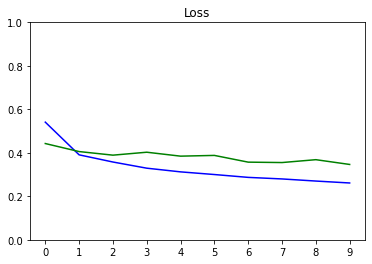

In [26]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

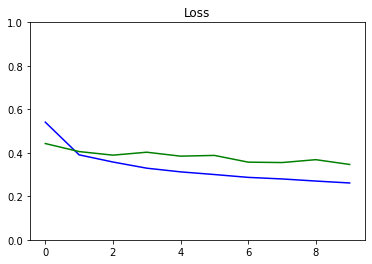

In [31]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

In [32]:
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

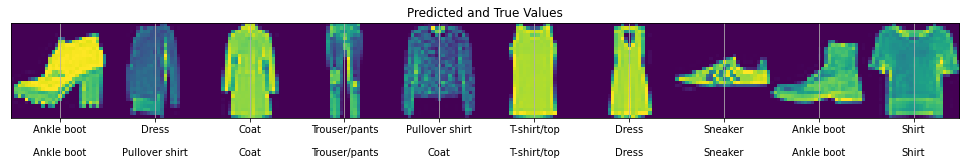

In [35]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)